In [1]:
import pathlib
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import backend as K
from tensorflow.keras.layers import Dropout
import datetime
import time
import os

In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [3]:
!pip install requests

In [4]:
from kerastuner.tuners import RandomSearch

<ipython-input-4-94471a811b41>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Regresja liniowa w KERAS


Celem projketu jest zaimplementowanie sieci neuronowej z zastosowaniem biblioteki KERAS do rozwiązania problemu regresji liniowej związanym z pozycjonowaniem zawodników w wyścigach Formuły 1 bazując na danych z innych wyścigów.

In [5]:
wyniki = pd.read_csv('./results.csv', na_values = "?", comment='\t')
wyniki.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22.0,1,1.0,1,1,10.0,58,34:50.6,5690616.0,39.0,2.0,01:27.5,218.3,1
1,2,18,2,2,3.0,5,2.0,2,2,8.0,58,5.478,5696094.0,41.0,3.0,01:27.7,217.586,1
2,3,18,3,3,7.0,7,3.0,3,3,6.0,58,8.163,5698779.0,41.0,5.0,01:28.1,216.719,1
3,4,18,4,4,5.0,11,4.0,4,4,5.0,58,17.181,5707797.0,58.0,7.0,01:28.6,215.464,1
4,5,18,5,1,23.0,3,5.0,5,5,4.0,58,18.014,5708630.0,43.0,1.0,01:27.4,218.385,1


In [6]:
wyścigi = pd.read_csv('./races.csv', na_values = "?", comment='\t')
wyścigi.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [7]:
pozycje = pd.read_csv('./driverStandings.csv')
pozycje.head()

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


In [8]:
ostatni_wyścig = pd.read_csv('./last_race.csv', na_values = "?", comment='\t')
ostatni_wyścig.head()

,Year,Race ID
0,2017,988
1,2016,968
2,2015,945
3,2014,918
4,2013,899


Operacje na danych ze wstępnych tabel, aby przygotować je do połaczenia.


In [9]:
ostatni_wyścig.rename(columns={'Race ID': 'raceId', 'Year':'year',}, inplace=True) #podmiana nazw, żeby skutecznie połączyć ze sobą tabele

In [10]:
wyścigi = wyścigi.drop(columns=['date', 'time', 'url']) #pozbycie się niepotrzebnych danych

In [11]:
wyścigi_od_2001 = wyścigi[wyścigi['year'] < 2001].index #interesują nas wyścigi od 2001
wyścigi = wyścigi.drop(index=wyścigi_od_2001)
wyścigi = wyścigi.sort_values(by=['year'])

In [12]:
wyścigi_2 = wyścigi.drop(columns=['round', 'circuitId', 'name']) #pozbycie się niepotrzebnych danych

In [13]:
wyścigi_id = wyścigi_2['raceId'].tolist()
raceId = wyniki['raceId'].isin(wyścigi_id)
wyniki_2 = wyniki[raceId]

In [14]:
wyniki_2 = wyniki_2.drop(columns=['number','position', 'positionText', 'points','time', 'statusId']) #pozbycie się niepotrzebnych danych

Połęczenie danych w jedną całość.


In [15]:
wyniki_2 = pd.merge(wyniki_2, wyścigi_2, on='raceId') #polączenie danych w jedną tabele na której będziemy operować
lista_zawodników = wyniki_2['driverId'].unique()
print(len(lista_zawodników))

105


In [16]:
ostatni_wyścig_2 = ostatni_wyścig['raceId'].tolist()

In [17]:
ostatni_wyścig_lista = pozycje['raceId'].isin(ostatni_wyścig_2)
pozycje_2 = pozycje[ostatni_wyścig_lista]

In [18]:
pozycje_2 = pozycje_2.drop(columns=['driverStandingsId', 'positionText', 'points', 'wins']) #pozbycie się niepotrzebnych danych

Połęczenie danych w jedną całość.

In [19]:
pozycje_2 = pozycje_2.sort_values(["raceId","driverId"])
pozycje_2 = pd.merge(pozycje_2, ostatni_wyścig, on='raceId')
pozycje_2.rename(columns={'position':'koncowe_pozycje'}, inplace=True)
lista_zawodników_2 = pozycje_2['driverId'].unique()
print(lista_zawodników_2)

[  1   2   3   4   5   6   7   8   9  10  12  13  15  16  17  18  20  21
  22  24  67  69 153 154 155  11  14  19  23  25  26  27  29  30  31  32
  33  34  35  36  37  38  39  40  42  41  43  44  45  46  47  48  49  50
  51  52  53  56  59  62  63  66  54  55  57  58  60  61  64  65 807 808
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843]


In [20]:
wyniki_koncowe = pd.merge(wyniki_2, pozycje_2, how='inner', on=['driverId', 'year'])
wyniki_koncowe = wyniki_koncowe.drop(columns=['resultId', 'raceId_x', 'driverId', 'constructorId', 'milliseconds', 'fastestLapSpeed', 'fastestLapTime','rank', 'year', 'raceId_y'])
dataset = wyniki_koncowe.dropna()

<Axes: >

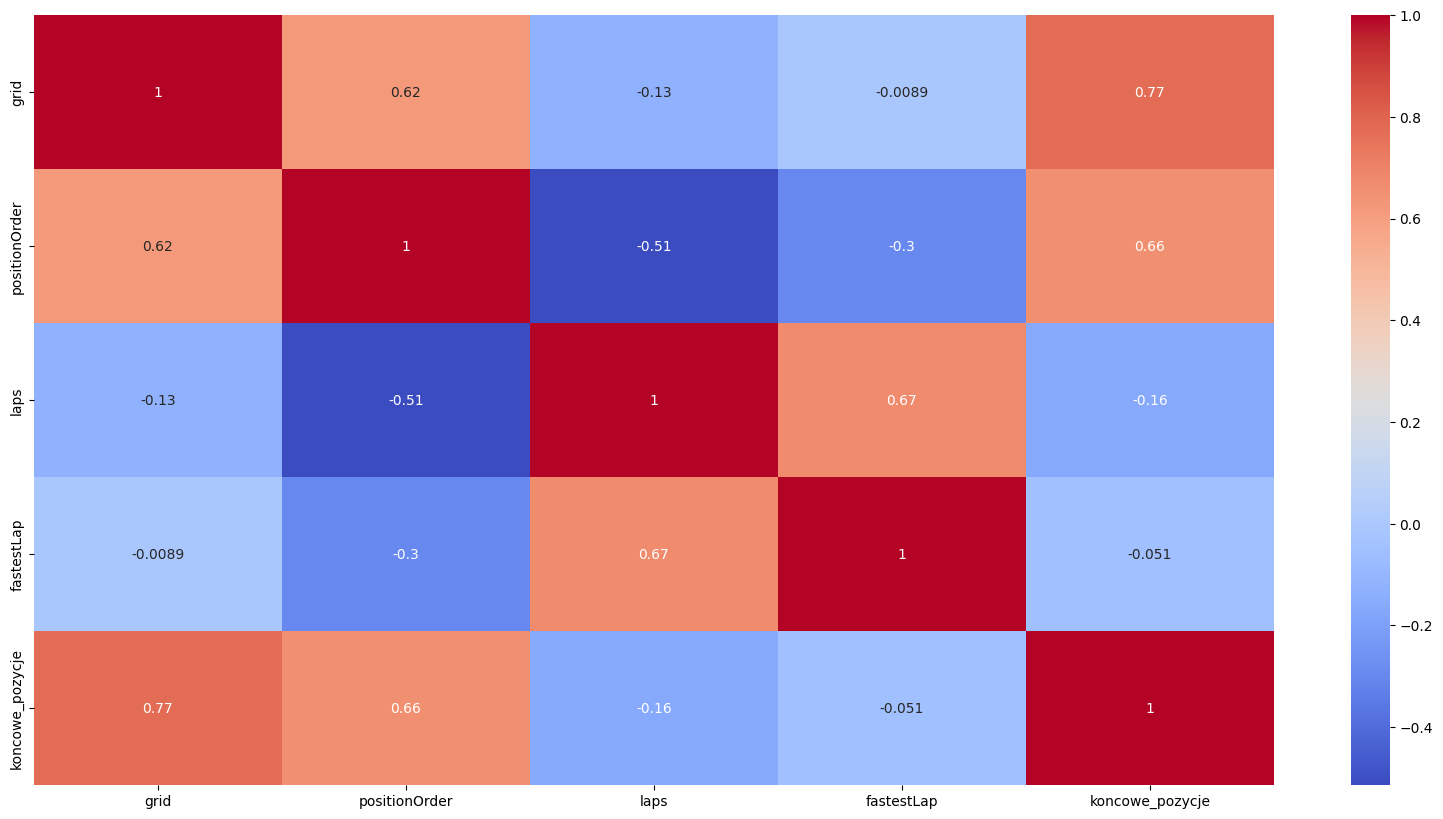

In [21]:
plt.figure(figsize=(20, 10))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm') #Mapa koleracji pomiędzy danymi

In [22]:
train_dataset = dataset.sample(frac=0.8,random_state=0) #Podział, na dane testowe i treningowe
test_dataset = dataset.drop(train_dataset.index)

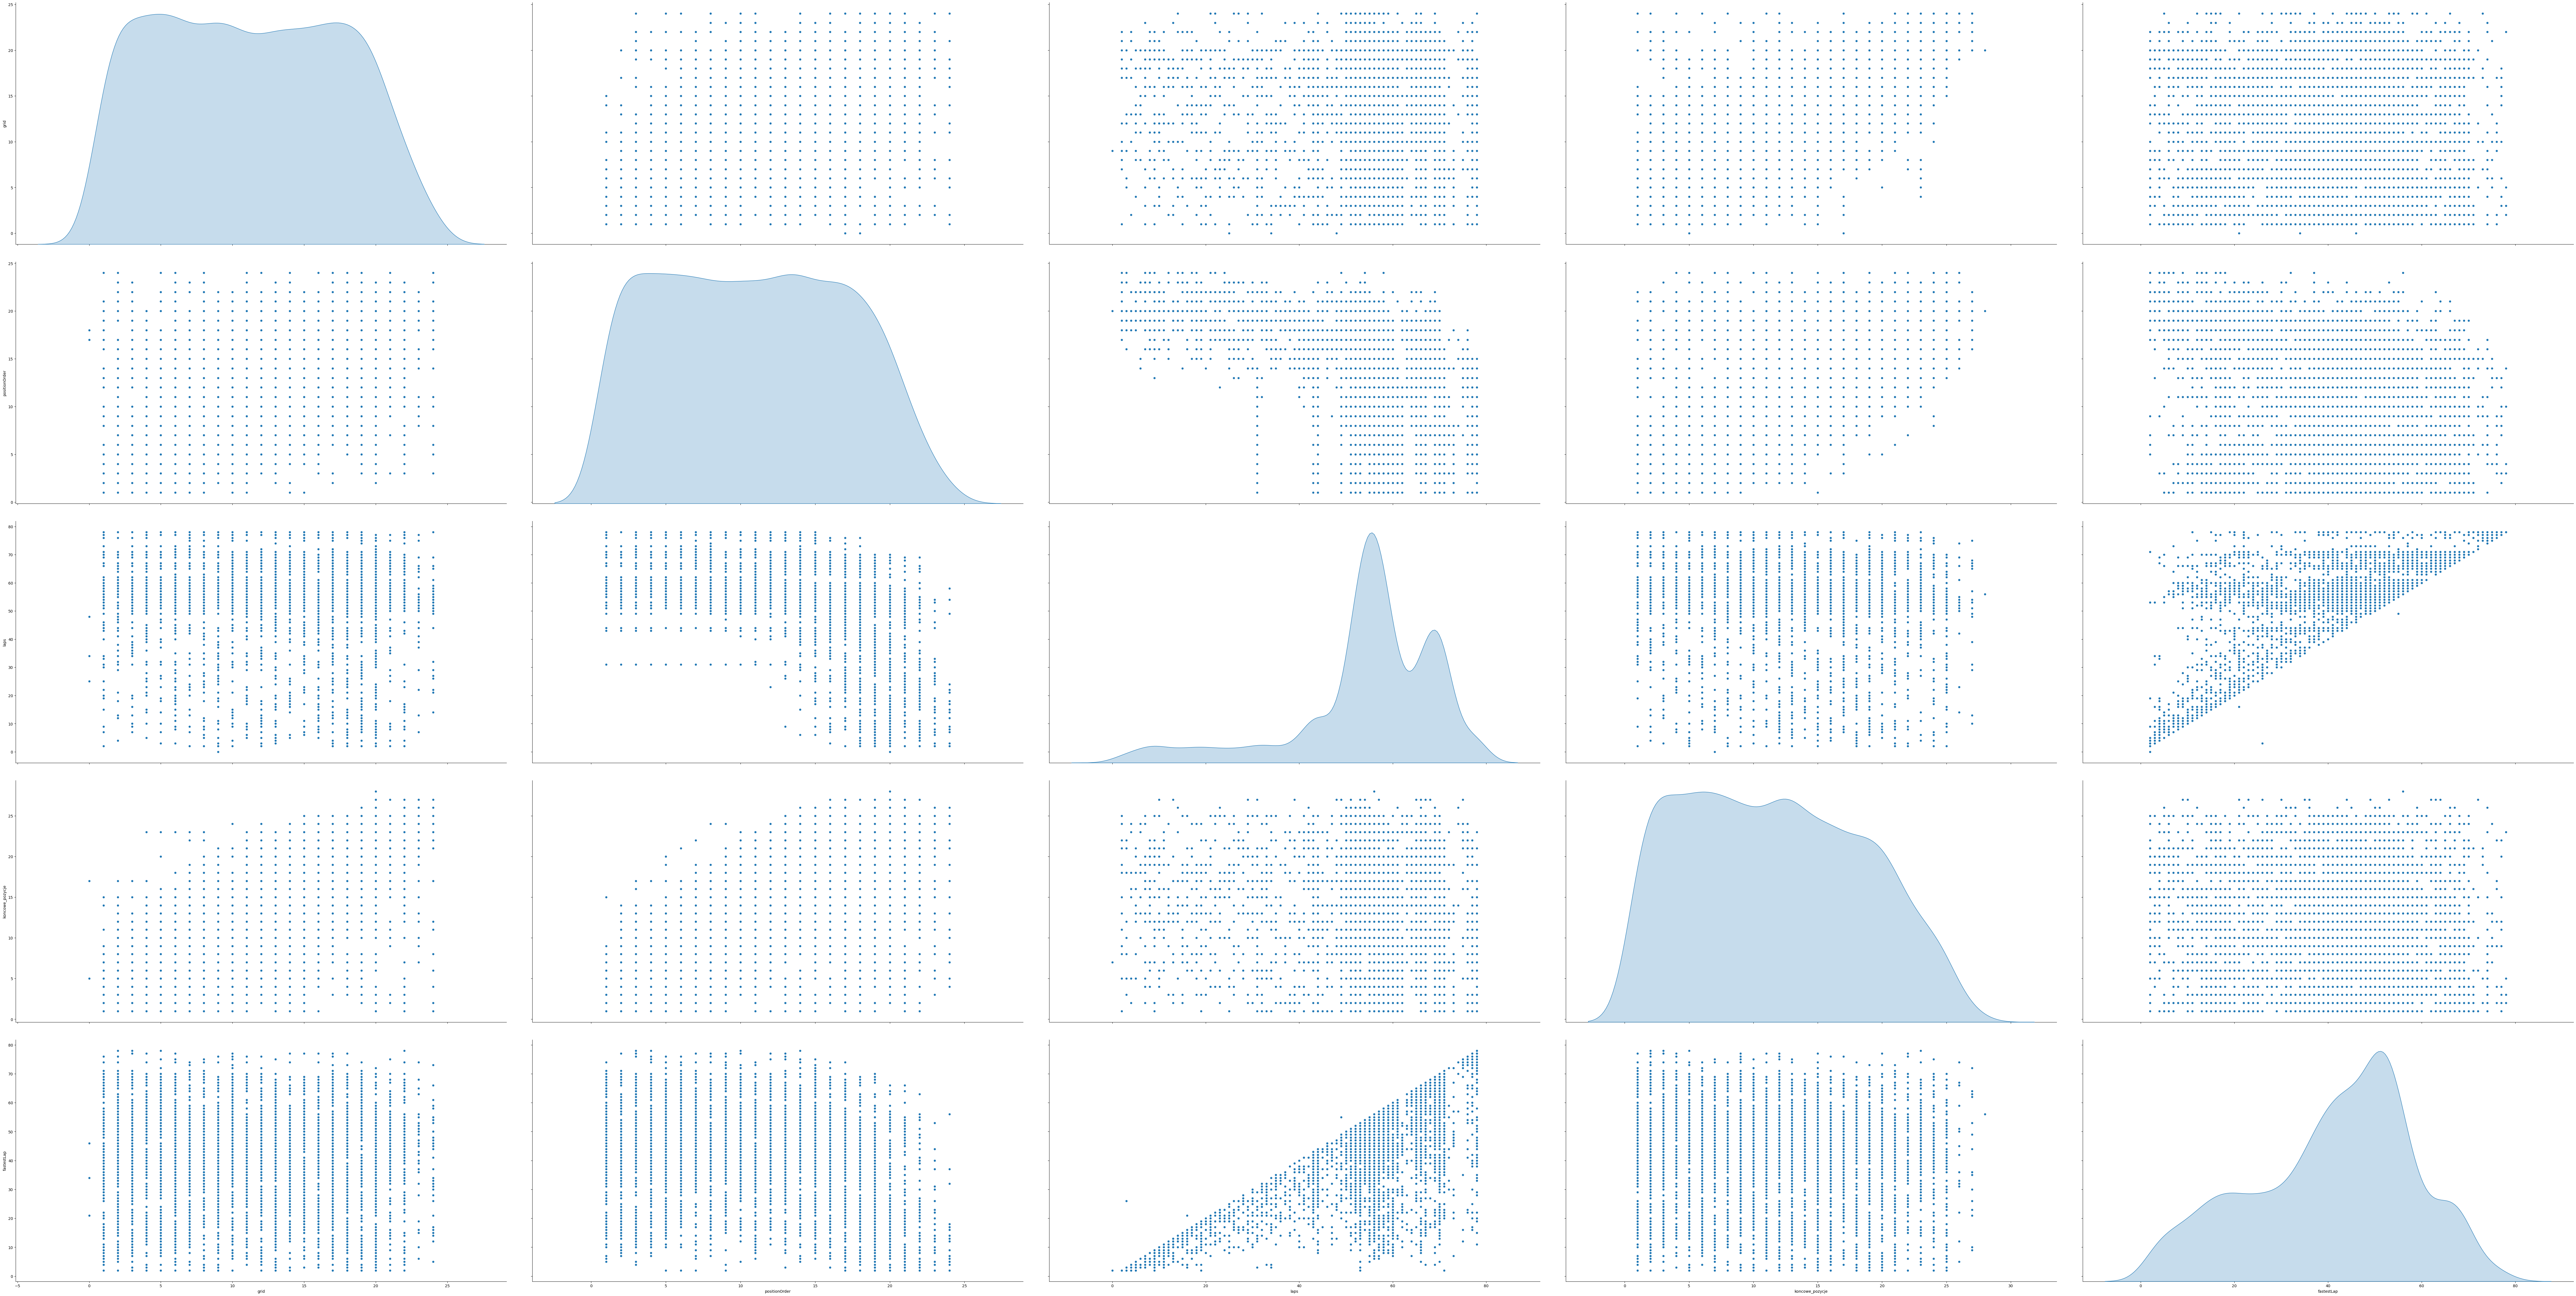

In [23]:
g = sns.pairplot(train_dataset[["grid", "positionOrder", "laps", "koncowe_pozycje", "fastestLap"]], diag_kind="kde")
plt.gcf().set_size_inches(100, 50)

In [24]:
train_stats = train_dataset.describe()
train_stats.pop("koncowe_pozycje")
train_stats = train_stats.transpose()
print(train_stats)

                count       mean        std  min   25%   50%   75%   max
grid           4305.0  11.193496   6.344835  0.0   6.0  11.0  17.0  24.0
positionOrder  4305.0  10.859930   6.115192  1.0   6.0  11.0  16.0  24.0
laps           4305.0  54.436469  15.508833  0.0  52.0  56.0  66.0  78.0
fastestLap     4305.0  41.059001  17.110747  2.0  29.0  44.0  53.0  78.0


In [25]:
train_labels = train_dataset.pop('koncowe_pozycje')
test_labels = test_dataset.pop('koncowe_pozycje')

In [26]:
normed_train_data = (train_dataset - train_stats['mean']) / train_stats['std']  #Normalizacja danych
normed_test_data = (test_dataset - train_stats['mean']) / train_stats['std']


In [27]:
print(normed_test_data)

          grid  positionOrder      laps  fastestLap
0    -1.606582      -1.612366  0.229774   -0.120334
7     0.284720      -0.140622  1.003527   -0.061891
21   -0.345714      -0.304149  0.745609   -1.172304
24   -0.503322      -1.448839  1.003527   -0.938533
25   -0.030497       0.349960  1.003527    0.288766
...        ...            ...       ...         ...
6705  1.072763       1.004068  0.036336    0.697865
6707  0.442329       1.331123 -3.187633   -2.282718
6708  0.284720       0.513487  0.939047    0.873194
6713  0.599937       0.513487  0.036336    0.230323
6719  0.915154       1.167595 -1.575648   -0.763205

[1076 rows x 4 columns]


In [28]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu', input_shape=(4, )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    return model

In [29]:
model = build_model()

model.compile(optimizer="adam",
                loss='mean_squared_error',
                metrics=['mean_absolute_error', 'mean_squared_error'])

In [30]:
history = model.fit(
  normed_train_data, train_labels,
  epochs=100, validation_split = 0.2, verbose=1)

Epoch 1/100
108/108 [==============================] - 6s 6ms/step - loss: 89.2657 - mean_absolute_error: 7.4952 - mean_squared_error: 89.2657 - val_loss: 28.1757 - val_mean_absolute_error: 4.1628 - val_mean_squared_error: 28.1757
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 23.0031 - mean_absolute_error: 3.7553 - mean_squared_error: 23.0031 - val_loss: 21.3132 - val_mean_absolute_error: 3.5552 - val_mean_squared_error: 21.3132
Epoch 3/100
108/108 [==============================] - 0s 5ms/step - loss: 18.9727 - mean_absolute_error: 3.3827 - mean_squared_error: 18.9727 - val_loss: 18.7933 - val_mean_absolute_error: 3.3312 - val_mean_squared_error: 18.7933
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 17.2153 - mean_absolute_error: 3.2002 - mean_squared_error: 17.2153 - val_loss: 17.3807 - val_mean_absolute_error: 3.1647 - val_mean_squared_error: 17.3807
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 1

In [31]:
test_acc = model.evaluate(normed_test_data, test_labels, verbose=0)
print(f"Średni błąd bezwględny wynosi: {test_acc[1]}")

Średni błąd bezwględny wynosi: 2.870490550994873


In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
95,13.717885,2.827970,13.717885,14.283301,2.864719,14.283301,95
96,13.677449,2.821851,13.677449,14.662092,2.906651,14.662092,96
97,13.766927,2.838779,13.766927,14.706972,2.881008,14.706972,97
98,13.705162,2.824337,13.705162,14.402973,2.885839,14.402973,98
99,13.695312,2.826220,13.695312,14.192710,2.870534,14.192710,99


In [33]:
model = build_model()

model.compile(optimizer="adam",
                loss='mean_squared_error',
                metrics=['mean_absolute_error', 'mean_squared_error'])

In [34]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [35]:
history = model.fit(normed_train_data, train_labels, epochs=100,
                    validation_split = 0.2, verbose=1, callbacks=[early_stop])

Epoch 1/100
108/108 [==============================] - 2s 6ms/step - loss: 106.5611 - mean_absolute_error: 8.2998 - mean_squared_error: 106.5611 - val_loss: 29.1549 - val_mean_absolute_error: 4.2647 - val_mean_squared_error: 29.1549
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 23.3554 - mean_absolute_error: 3.7361 - mean_squared_error: 23.3554 - val_loss: 22.0734 - val_mean_absolute_error: 3.6002 - val_mean_squared_error: 22.0734
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 19.6041 - mean_absolute_error: 3.4239 - mean_squared_error: 19.6041 - val_loss: 19.0940 - val_mean_absolute_error: 3.3338 - val_mean_squared_error: 19.0940
Epoch 4/100
108/108 [==============================] - 0s 5ms/step - loss: 17.4291 - mean_absolute_error: 3.2102 - mean_squared_error: 17.4291 - val_loss: 17.1903 - val_mean_absolute_error: 3.1593 - val_mean_squared_error: 17.1903
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss:

In [36]:
test_acc = model.evaluate(normed_test_data, test_labels, verbose=0)

In [37]:
print(f"Średni błąd bezwględny wynosi: {test_acc[1]}")

Średni błąd bezwględny wynosi: 2.858692169189453


In [38]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])


In [39]:
print(history_dict['mean_absolute_error'])

[8.299827575683594, 3.7361044883728027, 3.4238691329956055, 3.2102248668670654, 3.0771069526672363, 2.99922776222229, 2.9652390480041504, 2.9327402114868164, 2.9129741191864014, 2.905517101287842, 2.890859842300415, 2.8796226978302, 2.8833250999450684, 2.872821807861328, 2.8808658123016357, 2.869691848754883, 2.860588788986206, 2.870741844177246, 2.854006767272949, 2.85465669631958, 2.8562471866607666, 2.8683018684387207, 2.858208179473877, 2.875278949737549, 2.852792501449585, 2.85249924659729, 2.8578922748565674, 2.8472635746002197, 2.8557522296905518, 2.8573529720306396, 2.862133741378784, 2.8637235164642334, 2.8516108989715576, 2.8525640964508057, 2.865828037261963, 2.846360206604004, 2.8539609909057617, 2.8455593585968018, 2.8426883220672607, 2.84724497795105, 2.847050666809082, 2.847913980484009, 2.850360155105591, 2.842165231704712, 2.8447177410125732, 2.836291551589966, 2.8461813926696777, 2.844644069671631, 2.8377039432525635, 2.8567070960998535, 2.8430051803588867, 2.83405637

In [40]:
test_predictions = model.predict(normed_test_data).flatten()

34/34 [==============================] - 0s 2ms/step


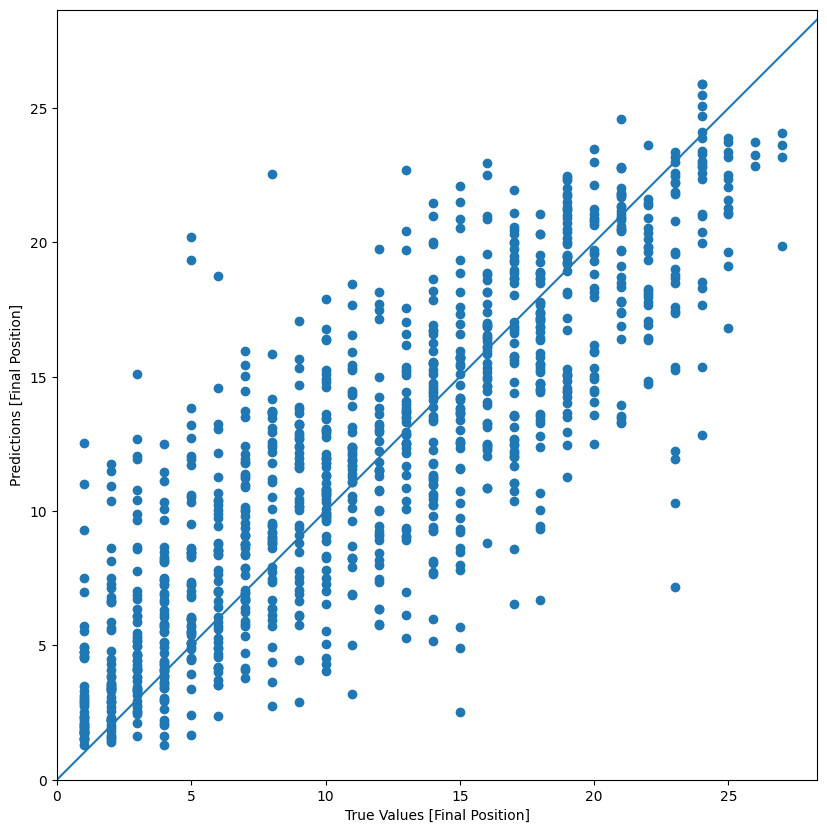

In [41]:
plt.figure(figsize=(20, 10))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Final Position]')
plt.ylabel('Predictions [Final Position]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])

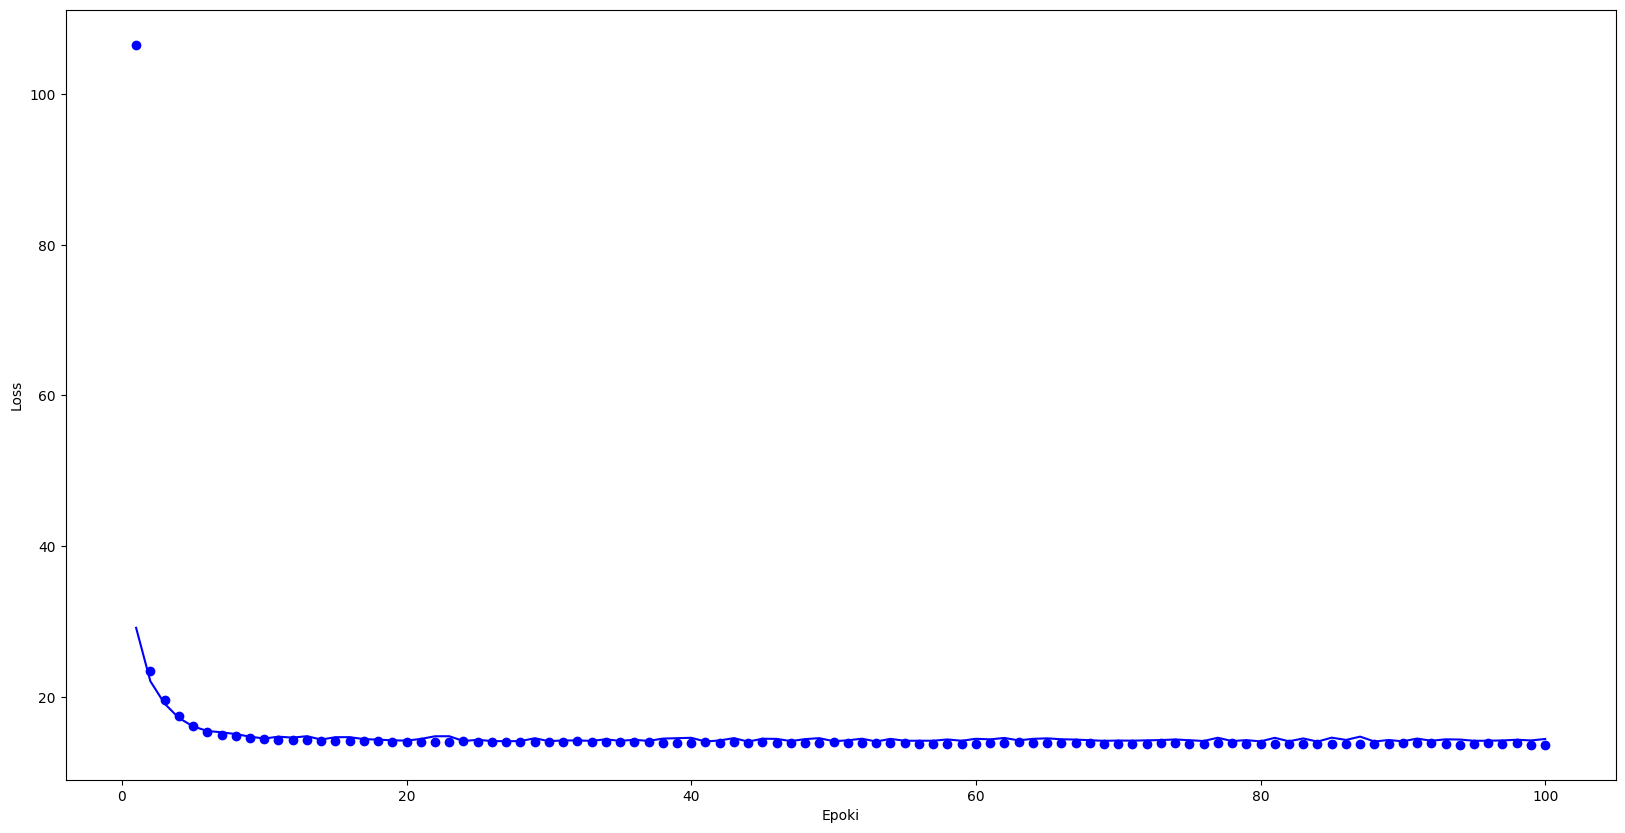

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(20, 10))
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.xlabel('Epoki')
plt.ylabel('Loss')
plt.show()

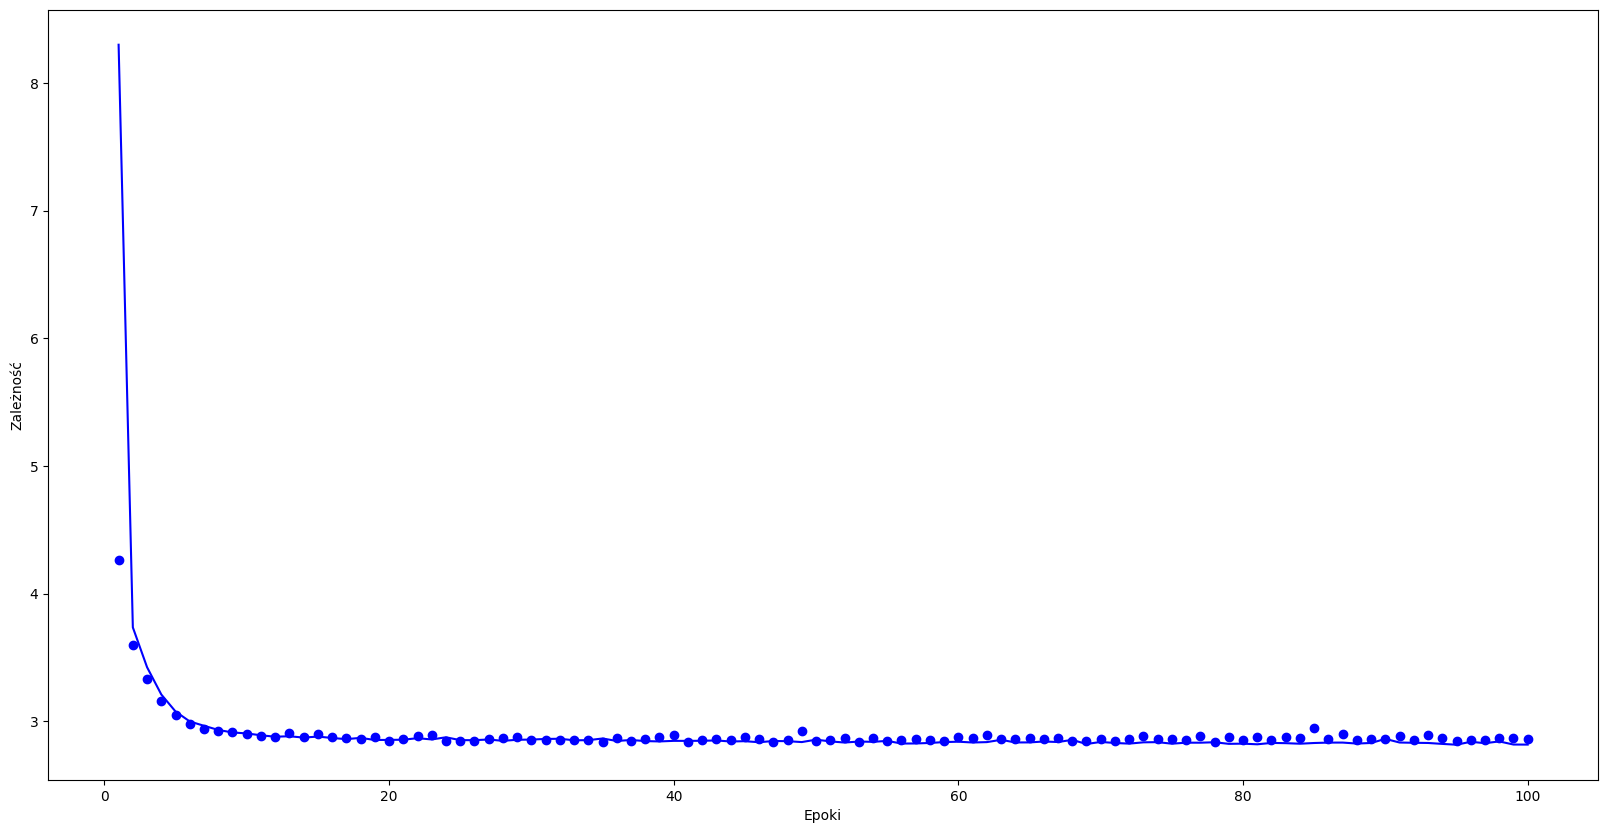

In [43]:
mean_abs = history.history['mean_absolute_error']
val_abs = history.history['val_mean_absolute_error']
plt.figure(figsize=(20, 10))
epochs = range(1, len(loss) + 1)
plt.plot(epochs, val_abs, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, mean_abs, 'b', label='Dokladnosc walidacji')
plt.title
plt.xlabel('Epoki')
plt.ylabel('Zależność')
plt.show()

# KERAS TUNER

In [44]:
import time
LOG_DIR = f"{int(time.time())}"

In [45]:
def build_model_dynamic(hp):
    model = models.Sequential()

    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', 'LeakyReLU','relu']

    model.add(layers.Dense(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=16),activation=hp.Choice("activation", activationL), input_shape=(4, )))

    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(layers.Dense(hp.Int('hidden_units',
                                min_value=32,
                                max_value=256,
                               step=16), activation=hp.Choice("activation", activationL)))

    dropout_rate = hp.Float('dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )

    model.add(Dropout(rate=dropout_rate))
    model.add(layers.Dense(1))

    hp_optimazer_rate = hp.Choice('optimazer', values=['sgd', 'rmsprop', 'adagrad', 'adam'])
    model.compile(optimizer=hp_optimazer_rate,
                loss=hp.Choice("loss", ["categorical_crossentropy","kl_divergence","mean_squared_error"]),
                metrics=['mean_absolute_error', 'mean_squared_error'])

    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    K.set_value(model.optimizer.learning_rate,  learning_rate)

    return model

In [46]:
tuner = RandomSearch(
    build_model_dynamic,
    objective='mean_absolute_error',
    max_trials=10,  # ile roznych modeli przetestowac?,
    executions_per_trial=1,  # ten sam model moze dawac rozne wyniki, stad ta opcja
    directory=LOG_DIR)

In [47]:
tuner.search(normed_train_data,
             train_labels,
             verbose=2,
             epochs=100,
             batch_size=512,
             validation_split = 0.2)

Trial 10 Complete [00h 00m 22s]
mean_absolute_error: 11.58518123626709

Best mean_absolute_error So Far: 2.8027820587158203
Total elapsed time: 00h 02m 28s


In [48]:
tuner.get_best_hyperparameters()[0].values

{'input_units': 176,
 'activation': 'LeakyReLU',
 'n_layers': 10,
 'hidden_units': 224,
 'dropout': 0.1,
 'optimazer': 'adagrad',
 'loss': 'mean_squared_error',
 'learning_rate': 0.01}

In [49]:
super_model = tuner.get_best_models()[0]
super_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 176)               880       
                                                                 
 dense_1 (Dense)             (None, 224)               39648     
                                                                 
 dense_2 (Dense)             (None, 224)               50400     
                                                                 
 dense_3 (Dense)             (None, 224)               50400     
                                                                 
 dense_4 (Dense)             (None, 224)               50400     
                                                                 
 dense_5 (Dense)             (None, 224)               50400     
                                                                 
 dense_6 (Dense)             (None, 224)               5

In [50]:
from sklearn.metrics import mean_absolute_error, r2_score

In [51]:
print(test_predictions)

[ 1.7458932 12.527331  10.040318  ... 14.723029  16.410204  18.475527 ]
